# Stable Diffusionまるわかり! パート1 -- Grokking Stable Diffusion

# はじめに

_Jonathan Whitaker氏(Twitter: [@johnowhitaker](https://twitter.com/johnowhitaker))がより詳しく解説をした、2本のノートブック([Part 1 - 基本編](https://colab.research.google.com/drive/1dlgggNa5Mz8sEAGU0wFCHhGLFooW_pf1?usp=sharing), [Part 2 - Text Inversion解説](https://colab.research.google.com/drive/1RTHDzE-otzmZOuy8w1WEOxmn9pNcEz3u?usp=sharing))を作成しています。氏のご厚意で、これらのソースコード、及び解説の翻訳、再頒布に了解をいただきました。以降は、Part 1ノートブックを元に、tomo-makes (Twitter: [@tomo_makes](https://twitter.com/tomo_makes))にて翻訳、加筆を行なったものです。_


# Stable Diffusionを理解する

Stable Diffusionについて遊んでいて（遊んでいない人はいないでしょう）、拡散モデルについての学習教材をどのように構成するかを考え始めました。このノートブックは基本的に、私 (訳者注: Jonathan氏) が初めてこのモデルに手を出したときの簡略版で、個々のパーツを理解（「理解」）しようとし、それらをどのようにレッスンの一部として提示できるかを考えています。

これは最終的には、より大きなコース（近日発表！）の、より洗練された構成要素になる予定ですが、このクールな新しいおもちゃを使いこなそうとしている他の人たちのために、今これを共有しないわけにはいきません。質問があれば私 @johnowhitaker に連絡するか、AIAIART discord（リンクは https://github.com/johnowhitaker/aiaiart の readme にあります）に参加して、このことについてチャットしましょう（数日後にはビデオ・ウォークスルーもできるかもしれませんね）。

OK、もう背景説明は十分でしょう。あとは楽しんでください！ ハッピーハッキング :)


## セットアップとインポート

ここでは、ライブラリをインストールし、Hugging Faceにログインして（モデルをダウンロードするにはライセンス条項に同意する必要があります）、デモに必要なものをいくつかインポートします。

In [1]:
!pip install transformers diffusers==0.2.4 # For now specific version needed as update broke something

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 14.8 MB/s 
     |████████████████████████████████| 112 kB 68.8 MB/s 
     |████████████████████████████████| 163 kB 73.7 MB/s 
     |████████████████████████████████| 7.6 MB 42.2 MB/s 


In [2]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [3]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

## モデルのロード

このコード（と次のセクションのコード）は[Huggingface example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb)に由来しています。

これはこれから使う関連するモデルとコンポーネントをダウンロードし、セットアップします。とりあえずこれを実行し、次のセクションに進んで、より深く掘り下げる前にすべてがうまくいくことを確認しましょう。


In [4]:
# 潜在空間を画像空間にデコードするためのVAEモデルを読み込む
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# トークナイズとテキストのエンコード用に、tokenizerと、text_encoderを読み込む
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 潜在空間を生成するためのU-Netモデルの指定
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

# ノイズスケジューラの指定
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# モデルをGPUへ移す
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.13.self_attn.v_proj.weight', 'vision_model.embeddings.patch_embedding.weight', 'vision_model.encoder.layers.15.self_attn.q_proj.bias', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.bias', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder.layers.21.mlp.fc1.bias', 'vision_model.encoder.layers.3.self_attn.k_proj.bias', 'vision_model.encoder.layers.11.mlp.fc2.weight', 'vision_model.encoder.layers.5.self_attn.k_proj.bias', 'vision_model.encoder.layers.19.self_attn.k_proj.bias', 'vision_model.encoder.layers.12.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.mlp.fc2.bias', 'vision_model.encoder.layers.0.layer_norm2.bias', 'vision_model.encoder.layers.8.self_attn.k_proj.bias', 'vision_model.encoder.layers.13.self_attn.v_proj.bias', 'vision_model.encoder.layers.0

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## 拡散生成ループ

繰り返しますが、今は基本的に[HF notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb)にあるコードを実行しているだけです。

もし、これだけでいいのなら、このノートブックを無視して、既存のツール([DreamStudio](https://beta.dreamstudio.ai/)など)を使うこともできますし、huggingfaceの簡易パイプライン(ドキュメント[こちら](https://huggingface.co/blog/stable_diffusion)を利用することもできます。

このノートブックでやりたいことは、これがどのように機能するかをもう少し深く掘り下げることです。そこで、まず、例のコードが実行されることを確認することから始めます。


0it [00:00, ?it/s]

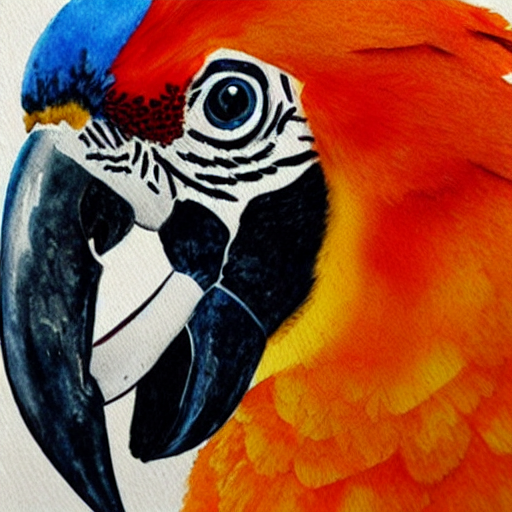

In [9]:
# 設定
prompt = ["A watercolor painting of a macaw"]
height = 512                        # Stable Diffusion標準の出力画像サイズ (高さ)
width = 512                         # Stable Diffusion標準の出力画像サイズ (幅)
num_inference_steps = 50            # ノイズ除去のステップ数
guidance_scale = 7.5                # ガイダンスの強さ
generator = torch.manual_seed(32)   # 潜在空間のノイズ生成のためのシード生成
batch_size = 1

# テキストの準備
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# スケジューラの準備
scheduler.set_timesteps(num_inference_steps)

# 潜在ベクトルの準備
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# ループの実行
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # 分類器不要のガイダンスを行う場合は、2回のフォワードパスを行わないように潜在ベクトルを拡張する
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # ノイズの残差を予測する
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # ガイダンスを実行する
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # ひとつ前のサンプルを計算する x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

# 画像の拡大縮小とVAEによる復号化
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents)
  
# 生成画像の表示
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

動作はするけど、どういう意味があるのでしょう？
ここでは、さまざまな構成要素を一つずつ見ていきましょう。


## オートエンコーダ(AE)

オートエンコーダは、画像を潜在表現に「エンコード (符号化) 」したり、その潜在表現から画像に「デコード (復号化) 」することができます。別の言葉で言うと、全てのピクセルを表現した元データから、より少ない潜在ベクトルへ情報を圧縮したり、圧縮した情報から元の画像を復元することができます。

このコードをいくつかの関数にまとめましたので、実際にどのようなものかを見てみましょう。


In [11]:
# Using torchvision.transforms.ToTensor
to_tensor_tfm = tfms.ToTensor()

def pil_to_latent(input_im):
  # Single image -> single latent in a batch (so size 1, 4, 64, 64)
  with torch.no_grad():
    latent = vae.encode(to_tensor_tfm(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
  return 0.18215 * latent.mode() # or .mean or .sample

def latents_to_pil(latents):
  # bath of latents -> list of images
  latents = (1 / 0.18215) * latents
  with torch.no_grad():
    image = vae.decode(latents)
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

実際にWeb上の画像、またはご自身の画像を使ってVAEによるエンコード、デコードを試してみましょう。
代わりに自分の写真をアップロードして、以下のコードでファイル名を編集することで読み込むことができます。

In [14]:
# 画像のダウンロード
!curl --output macaw.jpg 'https://pbs.twimg.com/profile_images/1482289137692540929/gYkbdni-_400x400.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34351  100 34351    0     0   104k      0 --:--:-- --:--:-- --:--:--  104k


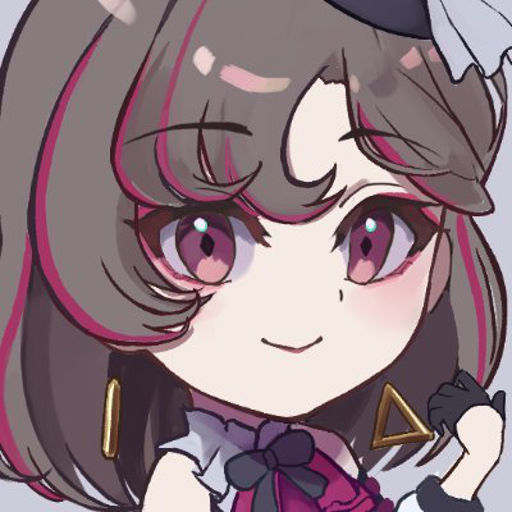

In [15]:
# 画像をPILで読み込む
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

エンコードには、先ほど定義した `pil_to_latent()` 関数を使います。引数に入力画像を渡します。

In [16]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

`512 x 512`の画像から、`torch.Size([1, 4, 64, 64])`のサイズの潜在ベクトルが得られました。情報が圧縮されていることがわかります。次に、デコードには先ほど定義した`latents_to_pil()`関数を使います。引数に潜在ベクトルを渡します。すると、画像が復元されました。

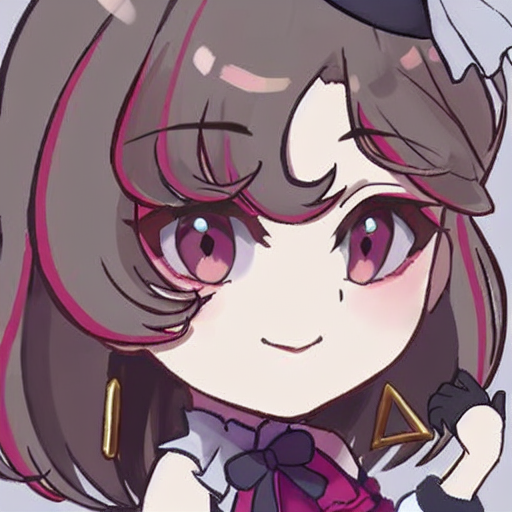

In [17]:
# Decode this latent representation back into an image
decoded = latents_to_pil(encoded)[0]
decoded

目を細めると小さな違いが見えてくるかも？もし、何も見えなければ目をつぶってくださいね。この `4 x 64 x 64` の潜在ベクトルは、縦横 `64px` の画像よりも多くの情報を保持しているようです。

このオートエンコーダは、画像をより小さな表現に圧縮し、その圧縮表現から再び画像を作成するよう、学習しています。

この場合、8倍（512 / 8 = 64）に圧縮されるため、 `8　x　8`　pxのパッチは4つの数値（オートエンコーダ出力の4チャンネル）に圧縮されます。より高い圧縮率（例えば、VQGANモデルでよく使われているようなf16）のオートエンコーダを見つけることができますが、ある時点で、私たちが望まないアーティファクトが発生し始めます。

なぜ、オートエンコーダを使うのでしょう？

モデルはすべての画像データを入力として受け取り、同じ形状の出力予測を生成します。これは大量のデータを処理することを意味します。つまり、高解像度の生成には高い計算コストがかかります。

この解決策の一つは、低解像度（例えば `64 x 64` px）で拡散を行い、その後、（D2/Imagenのように）繰り返しアップスケール (高解像) をかけるような別のモデルを適用することです。しかし、Stable Diffusionでは、生画像ではなく、オートエンコーダから圧縮された表現を用いて、この「潜在空間」で拡散生成処理を行います。ここで扱われる潜在表現の情報量は豊富で、ご自宅のコンピュータで実行できるほど小さくすることができます。潜像表現として新しい「画像」を生成したら、オートエンコーダはそれらの最終的な潜像出力を受け取り、実ピクセルに変換できます。


## The Scheduler

## スケジューラ

モデルは、
- 学習用データセットの画像にノイズを加える
- モデルに加えられたノイズを予測させる（つまり、ノイズを加える前の画像を予測していることにもなる）
というサイクルで学習されています。

ノイズが多すぎてもノイズを加える前の画像の予測は困難です。ほんの少しのノイズしか加えなければ、モデルはノイズを推定する能力を獲得できません。バランスが重要です。そのため、学習時には、ある分布に従って、ノイズの量を変化させます。

サンプリング (推論) 時には、何段階かに分けてノイズ除去を行います。そのステップ数、ノイズの量が、生成される画像に影響します。

スケジューラが、これらのパラメータを決定します。例えば:
`scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)` は、モデルの学習に使ったスケジューラとパラメータを一致させています。より少ないステップ数でサンプリングしたい場合、`scheduler.set_timesteps`で、ステップ数を変更します。


In [18]:
# サンプリングステップ数の設定
scheduler.set_timesteps(15)

新しいステップが、学習に使ったステップとどう対応しているかわかります。


In [19]:
# 学習時の1000ステップに換算して確認する
print(scheduler.timesteps)

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000], dtype=torch.float64)


ノイズレベルを確認し、グラフにプロットしてみます。

In [20]:
# 等価なノイズレベルを確認する
print(scheduler.sigmas)

tensor([14.6147,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000],
       dtype=torch.float64)


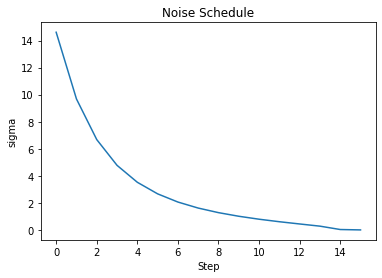

In [21]:
#@markdown ノイズスケジュールをプロットする
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Step')
plt.ylabel('sigma')
plt.show()


この「シグマ」は潜在表現に加えられるノイズの量です。符号化された画像に少しノイズを加え、このノイズを加えたものを復号化することで、どう見えるか確認してみましょう。

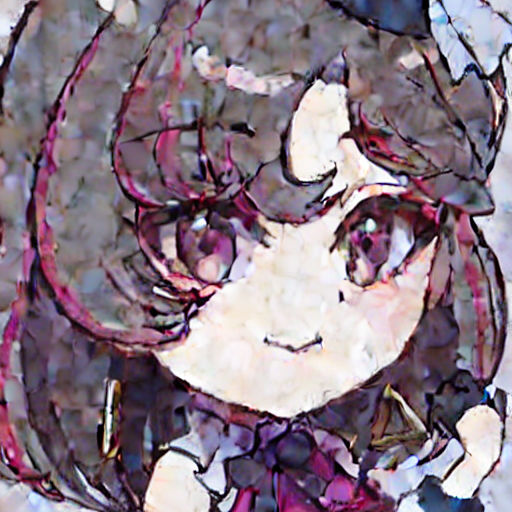

In [24]:
# ノイズありのバージョンを確認する
noise = torch.randn_like(encoded) # ランダムノイズを発生させる
timestep = 150 # 例えば、学習時の 150/1000 ステップ目と同じ
encoded_and_noised = scheduler.add_noise(encoded, noise, timestep)
latents_to_pil(encoded_and_noised)[0] # 表示する

t=300、500、999ではどのように見えるでしょうか？試して見てください :)

## ノイズを入力としたループの開始

初期化に画像を使い、そこにノイズを加え、新しいプロンプトを使ったループ最後のノイズ除去数ステップを実行するとどうなるでしょうか。画像を、ノイズを付加した画像から再作成します。

最初のデモと似たループを使いますが、最初の `start_step` のステップを飛ばします。

画像にノイズを加えるには、上に示したようなコードを使います。`timestep = int(scheduler.timesteps[start_step])` とすると、適切な量のノイズを加えられます。もちろん、これを微調整してstart_stepに依存しないようにすることもできます。しかし、スケジュールに従うのが一番よさそうです。


0it [00:00, ?it/s]

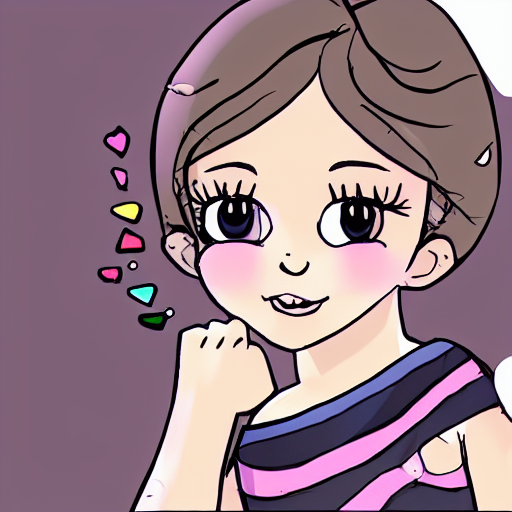

In [27]:
#@title この画像のノイズを付加した画像から再作成する
prompt = ["cute girl, animation"] #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Start step
start_step = 10 #@param Explore ;)
start_sigma = scheduler.sigmas[start_step]
start_timestep = int(scheduler.timesteps[start_step])

# Prep latents
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, start_timestep)
latents = latents.to(torch_device)
latents = latents * start_sigma  # << NB

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i > start_step:
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

latents_to_pil(latents)[0]

出力画像から、いくつかの色と構造が維持されていることがわかります。でも、もうすっかり新しい画像になっていますね。やってみると分かりますが、ノイズを加えれば加えるほど、ステップ数を増やせば増やすほど、入力画像から遠ざかっていきます。

これがimg2img (Image-to-Image) パイプラインの仕組みです。もちろん、img2imgを実行するだけであれば、Webアプリなどから実行した方が早いのですが、ステップを追って、そのメカニズムを確認してみました。

これはtxt2imgの生成ループと基本的に同じであって、最初の数ステップをスキップし、初期値として与えるものが純粋なノイズではなく、ノイズの入った画像で初期化していることがわかりました。

# テキストエンコーダ

さて、与えるプロンプトは、どのようにしてモデルの画像生成に使えるようになるのでしょうか。

ここではテキストエンコーダ（通常はTransformerモデル）を使います。Stable Diffusionは、OpenAIのCLIPテキストエンコーダを使っています。CLIPは、テキストの非常に豊かな表現と画像の関係性をすでに学習しているTransformerモデルです。

ここから、テキストで表現されたプロンプトから、拡散生成モデルに直接与えられる形式である、埋め込みベクトル表現へ変換するプロセスを見ていきましょう。

In [28]:
# プロンプト文を作る
prompt = 'Cave painting of a bird, flooble'

In [29]:
# 最初に、プロンプト文をトークンの列に変換する
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # View the tokens

tensor([49406,  9654,  3086,   539,   320,  3329,   267,  4062,  1059, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])


ここには、入力を表すトークンと共に、いくつかの特別なトークンが含まれています。
たくさんの `49407` が含まれていることが分かります。これは、これは特別に定義した、隙間を埋めるためのトークン (padding token) です。多くの単語はそれ自身に対応したトークンになります。「flooble」のような未知語は、トークナイザによっていくつかに分割され、トークン化されます。以下のように、トークンを一つずつデコードして、トークナイザが処理をした様子が確認できます。


In [30]:
# 最初の入力を表すトークンをデコードしてみる
tokenizer.decoder.get(9654)

'cave</w>'

In [31]:
# 最後の2トークンをデコードしてみる
print(4062, tokenizer.decoder.get(4062))
print(1059, tokenizer.decoder.get(1059))

4062 floo
1059 ble</w>


それぞれ、`cave</w>`と、`4062 floo  1059 ble</w>`  が結果として得られました。「flooble」が二つに分割して解釈されていることが分かりますね。

さて、固定長の入力トークンが作れたので、次はこれを埋め込みベクトル (embeddings)に変換します。ここで少し混乱する用語があるので、説明しておきましょう。

トークンが最初にテキストモデルに渡されるとき、学習された埋め込みベクトルのセットを使って、各トークンからベクトルを作成します。これがモデルの入力埋め込みベクトルです。これらの入力埋め込みベクトルは、次にテキストモデル (Transformer) に渡され、新しい埋め込みベクトルセットを出力します。私たちが使っているのはこの出力埋め込みベクトルで、注意機構 (Attention) とTransformerモデルの魔法のおかげで、単語の埋め込みをバラバラにしたものよりも、プロンプト全体の文脈を取り込み、より豊かな表現をうまく捉えることができます。

最終的な埋め込みベクトルはこうなります。

In [ ]:
# 埋め込みベクトルを取得する
embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', embeddings.shape)
embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.1967,  0.3905, -1.1450,  ..., -0.9653,  2.0285,  0.2323],
         [-0.1163,  0.4147, -1.2173,  ..., -0.6865, -0.3320,  1.5457],
         ...,
         [-0.3868, -0.0672, -0.0636,  ..., -1.5762,  0.1958, -0.1945],
         [-0.3894, -0.0515, -0.0919,  ..., -1.5772,  0.2131, -0.1897],
         [-0.3998, -0.0703,  0.0162,  ..., -1.5541,  0.2430, -0.1985]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

77個のトークンの入力に対して、768次元の表現が得られました。これらは入力文字列に関する多くの「意味」を捉えています。拡散生成モデルが、ノイズ除去タスクにおいて、できるだけ多くの情報を使うことが期待できます。

これを使ってちょっと遊んでみましょうか。2つの入力を取り、それらの埋め込みベクトルの平均を取ります。それを最終的な埋め込みベクトルとしたら、どのような画像になるか見てみましょう。それぞれの重み付けは、 `mix_factor` で制御できます。

0it [00:00, ?it/s]

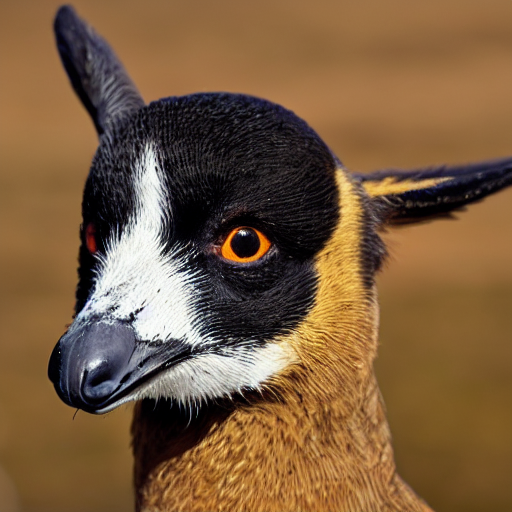

In [32]:
#@title re-generate starting from a noised version of this image
prompt1 = 'A dog' #@param
prompt2 = 'A bird' #@param
mix_factor = 0.4 #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text 
# Embed both prompts
text_input1 = tokenizer([prompt1], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings1 = text_encoder(text_input1.input_ids.to(torch_device))[0]
text_input2 = tokenizer([prompt2], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings2 = text_encoder(text_input2.input_ids.to(torch_device))[0]
# Take the average
text_embeddings = (text_embeddings1*mix_factor + \
                   text_embeddings2*(1-mix_factor))
# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]

latents_to_pil(latents)[0]

により、犬の成分が40%、鳥の成分が60%入った、キメラの画像が生成されました！

これは他の方法（例えば、個々のトークン埋め込みをいじって単語を組み合わせるなど）でも実現できます。
ただ、このあらあらのデモでもかなり楽しめてしまいますね。

似たようなアイデアの驚くべきアプリケーションとして、[TEXTUAL INVERSION](https://github.com/rinongal/textual_inversion) をチェックしてください。これは、いくつかの画像に基づき、ある特定の概念を表現する新しい疑似トークンを学習できます。彼らの[git repo](https://github.com/rinongal/textual_inversion)には、WIPとしてStable Diffusionのためのコードがあるので、もうすぐ簡単に遊べるようになるはずです。

とりあえず、先ほど生成された奇妙なあいつ (dog + bird = bog?) と目を合わせないようにしつつ、先に進むとしましょう…。

## U-NetとCFG

そろそろ拡散生成モデル本体を見てみます。

通常、ノイズを含む潜在表現(x)を入力に取り、ノイズを予測するU-Netモデルを使います。また、タイムステップ(t)とテキスト埋め込みベクトルを条件付けに使います。これらのパラメータを全てモデルに渡すとすると、以下のようになります。
`noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]` 

試しに、どのような出力がされるか見てみましょう。

In [33]:
# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# What is our timestep
t = scheduler.timesteps[0]
sigma = scheduler.sigmas[0]

# A noisy latent
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0]

# Text embedding
text_input = tokenizer(['A macaw'], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# Run this through the unet to predict the noise residual
with torch.no_grad():
  noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]

latents.shape, noise_pred.shape # We get preds in the same shape as the input

(torch.Size([1, 4, 64, 64]), torch.Size([1, 4, 64, 64]))

ノイズの多い潜在表現の集合が与えられると、このモデルはノイズ成分を予測します。

このノイズを、ノイズの多い潜在表現から取り除き、出力画像がどう見えるか確認します（`latents_x0 = latents - sigma * noise_pred` ）。

そして、この予測された出力にノイズを加えて、次の拡散生成ステップのための（できれば少しノイズを減らした）入力とします。これを表示するために、各ステップの後に予測された出力（x0）と次のステップ（xt-1）の両方を保存した別の画像を生成してみましょう。

In [34]:
#@title Store the predicted outputs and next frame for later viewing
prompt = 'Cave painting of a macaw' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Make a folder to store results
!rm -rf steps/
!mkdir -p steps/

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred
    im_t0 = latents_to_pil(latents_x0)[0]

    # And the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(f'steps/{i:04}.jpeg')

0it [00:00, ?it/s]

In [35]:
#@title Make and show the progress video
!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=1024 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

右は、各ステップで予測される「最終出力」(x0)を示しています。これは通常、生成過程を示すビデオなどに使われています。左は「次のステップ」です。ビデオで見ると、特に初期段階で大きく変化しているように見えますが、ステップごとの変化は比較的小さいので、実際のプロセスはもっと緩やかです。

### 分類器なしガイダンス

デフォルトの設定では、モデルは私たちの求めるようには動いてくれないことがあります。プロンプトにうまく従わせたい場合、CFGと呼ばれるハックがあります。このビデオに良い説明があります(AI coffee break GLIDE)。

コードで言うと、以下のようになります。

`noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)` とします。

これは意外とうまくいきます :)　

## ガイダンス

さて、お待ちかねのコーナーがやってきました。この生成プロセスにどのような指示を加えられるでしょうか？

各ステップにおいて、先ほどのモデルを使ってxのノイズ成分を予測し、それを使って予測された出力画像を生成し、この画像に何らかの損失関数を適用することにします。

この関数は何でもいいのですが、超簡単な例でデモをしてみましょう。青が多い画像が欲しければ、青の成分が少ないピクセルは損失が大きくなるような損失関数を作ればいいのです。 

In [ ]:
def blue_loss(images):
  #　青チャンネルの値は0.9に対してどの程度離れているか:
  error = torch.abs(images[:,-1, :, :] - 0.9).mean() 
  return error

以下の「コードを表示」リンクよりコードを開いて、何が追加されたか確認してみてください（具体的には、ループの `ADDITIONAL GUIDANCE` セクションです）。これを実行してみて、何が起こっているのか説明しますね。

0it [00:00, ?it/s]

0 loss: 36.4375
10 loss: 8.390625
20 loss: 2.615234375
30 loss: 1.7763671875
40 loss: 1.6025390625


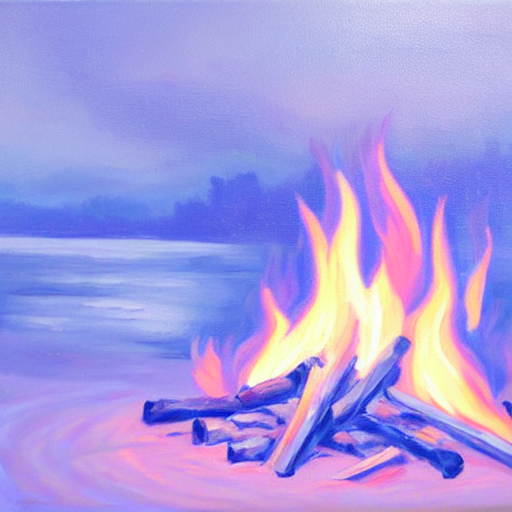

In [ ]:
#@title Store the predicted outputs and next frame for later viewing
prompt = 'A campfire (oil on canvas)' #@param
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50  #@param           # Number of denoising steps
guidance_scale = 8 #@param               # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1
blue_loss_scale = 40 #@param

# Make a folder to store results
!rm -rf steps/
!mkdir -p steps/

# Prep text 
text_input = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# And the uncond. input as before:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.sigmas[0] # Need to scale to match k

# Loop
with autocast("cuda"):
  for i, t in tqdm(enumerate(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)
    sigma = scheduler.sigmas[i]
    latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

    # predict the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

    # perform CFG
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    #### ADDITIONAL GUIDANCE ###
    # Requires grad on the latents
    latents = latents.detach().requires_grad_()

    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred

    # Decode to image space
    denoised_images = vae.decode((1 / 0.18215) * latents_x0) / 2 + 0.5 # (0, 1)

    # Calculate loss
    loss = blue_loss(denoised_images) * blue_loss_scale
    if i%10==0:
      print(i, 'loss:', loss.item())

    # Get gradient
    cond_grad = -torch.autograd.grad(loss, latents)[0]

    # Modify the latents based on this gradient
    latents = latents.detach() + cond_grad * sigma**2
    

    ### And saving as before ###
    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred
    im_t0 = latents_to_pil(latents_x0)[0]

    # And the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
    im_next = latents_to_pil(latents)[0]

    # Combine the two images and save for later viewing
    im = Image.new('RGB', (1024, 512))
    im.paste(im_next, (0, 0))
    im.paste(im_t0, (512, 0))
    im.save(f'steps/{i:04}.jpeg')

latents_to_pil(latents)[0]

異なる `blue_loss_scale` の値を使った例はこちらです:

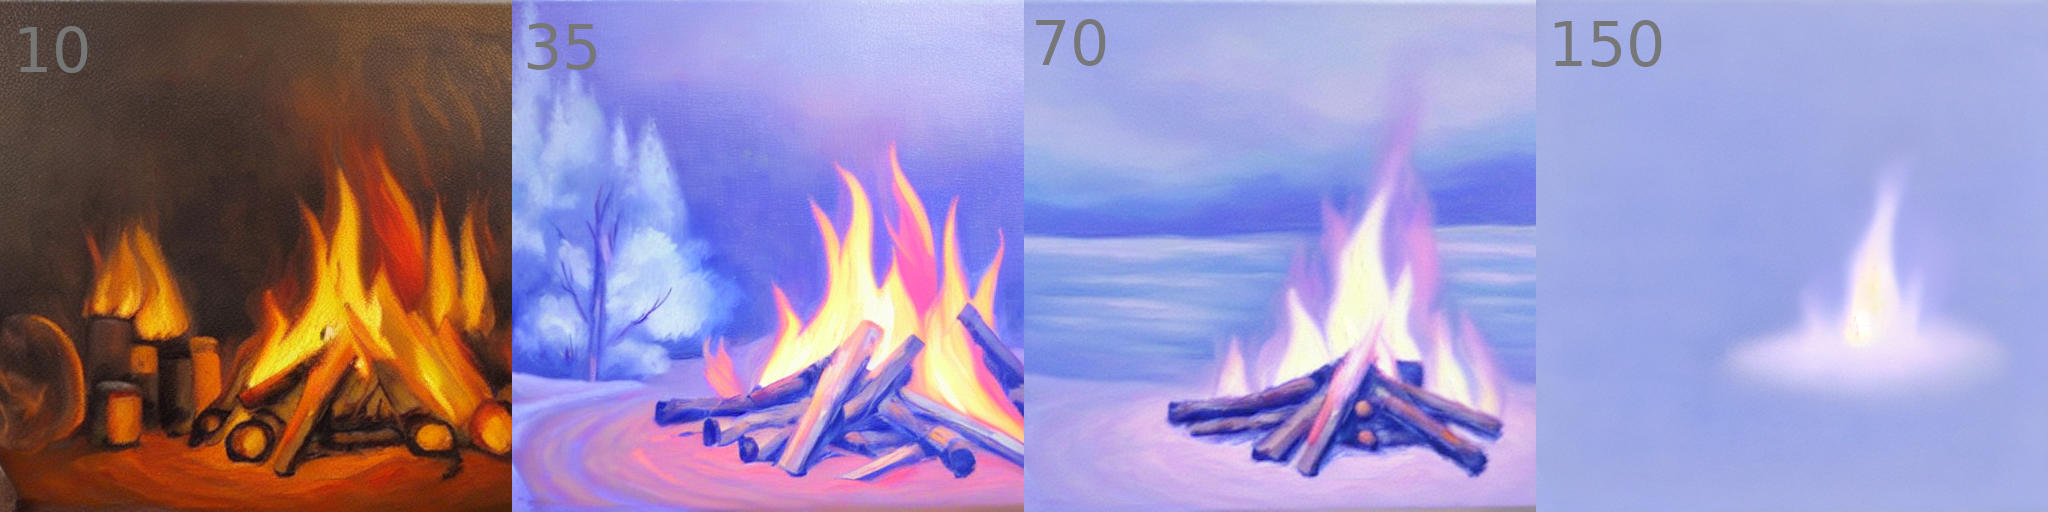


このプロンプト ('A campfire (oil on canvas)' つまり「キャンプファイヤーを油絵風で」) は、その言葉から分かる通り、出力は青系統には振れにくいものでした。そのため、スケールをかなり高く設定する必要があります。損失関数を追加しなければ、赤やオレンジ、そして暗い色になります。高めに設定（100または200）すると、求めた動作 (青系統の出力) に近づき始めます。

これはどんな仕組みなのでしょう？

ポイントは以下です:
- 予測される出力画像を見つける
- これに基づいて損失を求める
- 我々のX（潜在能力）に対する損失の勾配を求める
- この勾配を元に現在の X を修正する

損失を減らすために、各ステップで出力を「ナッジ」していることになります。損失をスケーリングすることで、この動きを制御できます（高過ぎると処理に影響を及ぼし、低過ぎると処理にあまり影響を及ぼさない）。

この例では、画像空間で損失を求めています。ステップごとに潜在表現をデコードし、AEのデコーダを通して勾配をトレースする必要があります。そのため、実行にはかなり時間がかかります。今のところ、CLIPガイダンスや知覚的類似性を見るにはこうしたデコード操作が必要です。しかし少し努力すると、この潜在表現を直接操作するモデルを訓練し、より高速なガイダンスを実現できるかもしれませんね。

ここで、より興味深い損失関数を発明するのは、親愛なる読者諸氏にお任せします。想像してみてください。

`loss = style_loss + perceptual_loss + masked_color_palette_complexity_loss + does_it_look_like_a_fish_loss + similarity_to_elvis + ...`

もうわかりましたね　:)


# おわりに

Stable Diffusionは素晴らしいモデルで、たくさんのことができます。このノートブックが、あなたがボンネットの下をもう少し覗くのに役に立ち、さらに探求し、あなた自身の実験を始める気になることを願っています。


### PS: このノートブックでは、いくつかのデモで固定シードを使用しています。もしこれが嫌なら、ノイズが生成されている場所から `generator=generator` を削除してください...。
